In [ ]:
import polars as pl
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
import scipy.stats as ss

In [2]:
try:
    data = pl.read_csv("exercise_13.csv")
except Exception as e:
    logger.error(e)

    data = {
        "year": range(1976, 1986),
        "accidents": [24, 25, 31, 31, 22, 21, 26, 20, 16, 22],
        "deaths": [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066],
        "death_rate": [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15],
    }

    data = pl.DataFrame(data)
    data.write_csv("exercise_13.csv", include_header=True)

data

year,accidents,deaths,death_rate
i64,i64,i64,f64
1976,24,734,0.19
1977,25,516,0.12
1978,31,754,0.15
1979,31,877,0.16
1980,22,814,0.14
1981,21,362,0.06
1982,26,764,0.13
1983,20,809,0.13
1984,16,223,0.03


In [3]:
data.describe()

statistic,year,accidents,deaths,death_rate
str,f64,f64,f64,f64
"""count""",10.0,10.0,10.0,10.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",1980.5,23.8,691.9,0.126
"""std""",3.02765,4.709329,252.389228,0.047422
"""min""",1976.0,16.0,223.0,0.03
"""25%""",1978.0,21.0,516.0,0.12
"""50%""",1981.0,24.0,764.0,0.14
"""75%""",1983.0,26.0,814.0,0.15
"""max""",1985.0,31.0,1066.0,0.19


# Question A

Model:
$$
\begin{align}
\theta & \sim \text{Gamma}(\alpha, \beta) \\
y & \sim \text{Poisson}(\theta)
\end{align}
$$
where:
- $\alpha$ and $\beta$ are the MLE estimators of the data

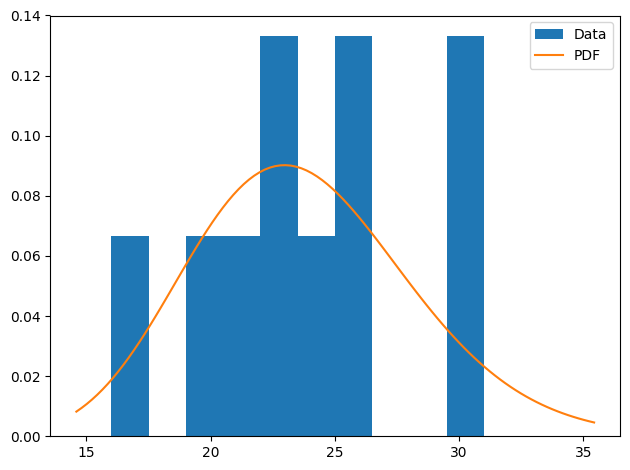

In [ ]:
params = ss.gamma.fit(data["accidents"])

x = np.linspace(ss.gamma.ppf(0.01, *params), ss.gamma.ppf(0.99, *params), 100)

plt.hist(data["accidents"], density=True, label="Data")
plt.plot(x, ss.gamma(*params).pdf(x), label="PDF")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
with pm.Model() as model_a:
    theta = pm.Gamma(
        "theta",
        mu=np.mean(data["accidents"].to_list()),
        sigma=np.std(data["accidents"].to_list(), ddof=1),
    )
    accidents = pm.Poisson("accidents", mu=theta, observed=data["accidents"].to_list())

    trace_a = pm.sample(2000, tune=1000)
    prior_a = pm.sample_prior_predictive(draws=1000)
    posterior_a = pm.sample_posterior_predictive(trace=trace_a)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [accidents, theta]
Sampling: [accidents]


Output()

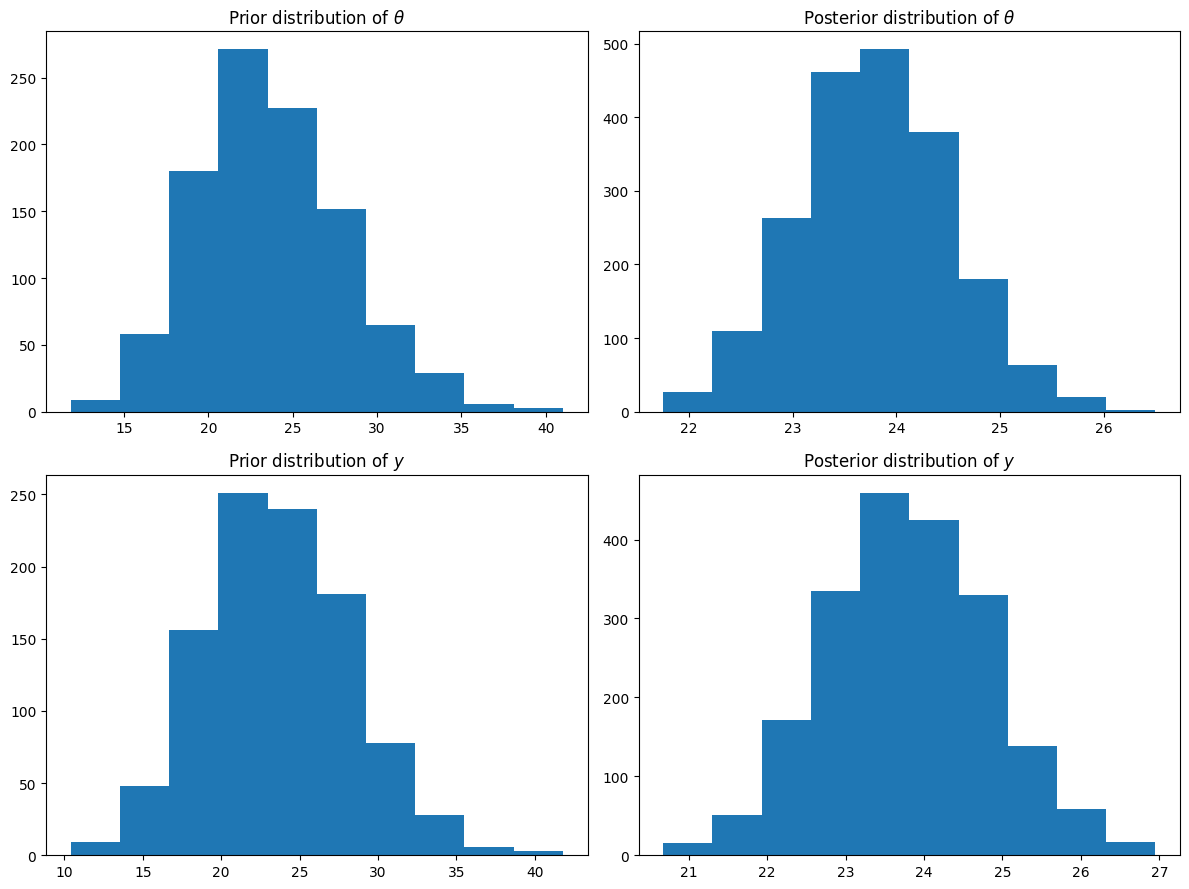

In [14]:
_, axes = plt.subplots(2, 2, figsize=(12, 9))

axes[0][0].hist(prior_a.prior["theta"].mean("chain"))
axes[0][1].hist(trace_a.posterior["theta"].mean("chain"))

axes[0][0].set_title(r"Prior distribution of $\theta$")
axes[0][1].set_title(r"Posterior distribution of $\theta$")

axes[1][0].hist(
    prior_a.prior_predictive["accidents"].mean(("chain", "accidents_dim_0"))
)
axes[1][1].hist(
    posterior_a.posterior_predictive["accidents"].mean(("chain", "accidents_dim_0"))
)

axes[1][0].set_title("Prior distribution of $y$")
axes[1][1].set_title("Posterior distribution of $y$")

plt.tight_layout()
plt.show()

In [15]:
np.percentile(
    posterior_a.posterior_predictive["accidents"].mean(("chain", "accidents_dim_0")),
    [2.5, 97.5],
)

array([21.799375, 25.925   ])

# Question B

Assumptions:
- the number of fatal accidents each year follows independent Poisson distribution with a constant rate and exposure in each year that is proportional to the number of passenger miles flown.

Goals:
- determine the posterior distirbution on the year.
- give a 95% predictive distribution for the number of fatal accidents in 1986 ($8 \times 10^{11}$ passenger miles are flown in that year)

Model:
- let $z_i$ be the number of passenger miles flown in the year $i$
- let the rate be $\theta$ and $x_i$ be the exposure for the year $i$
- let $y_i$ be the number of fatal accidents for the year $i$
$$
\begin{align}
\alpha & \sim \text{N}(0, 2) \\ 
\beta & \sim \text{N}(0, 2) \\ 
x_i & = \alpha + \beta \cdot z_i \\ 
y_i | x_i, \theta & \sim \text{Poisson}(x_i \cdot \theta)
\end{align}
$$

In [ ]:
data = data.with_columns((pl.col("deaths") / (pl.col("death_rate"))).alias("miles"))

data

year,accidents,deaths,death_rate,miles
i64,i64,i64,f64,f64
1976,24,734,0.19,3863.157895
1977,25,516,0.12,4300.0
1978,31,754,0.15,5026.666667
1979,31,877,0.16,5481.25
1980,22,814,0.14,5814.285714
1981,21,362,0.06,6033.333333
1982,26,764,0.13,5876.923077
1983,20,809,0.13,6223.076923
1984,16,223,0.03,7433.333333


In [60]:
with pm.Model() as model_b:
    miles = pm.Data("miles", data["miles"].to_numpy())
    alpha = pm.Normal("alpha", mu=0, sigma=2.0)
    beta = pm.LogNormal("beta", mu=0.0, sigma=1.0)
    exposure = pm.Deterministic("exposure", alpha + beta * miles)
    rate = pm.Gamma("rate", alpha=2, beta=5)
    mu = pm.Deterministic("mu", exposure * rate)
    accidents = pm.Poisson("accidents", mu=mu, observed=data["accidents"].to_numpy())

    trace_b = pm.sample(2000, tune=1000)
    prior_b = pm.sample_prior_predictive(1000)
    posterior_b = pm.sample_posterior_predictive(trace=trace_b)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, rate]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
Sampling: [accidents, alpha, beta, rate]
Sampling: [accidents]


Output()

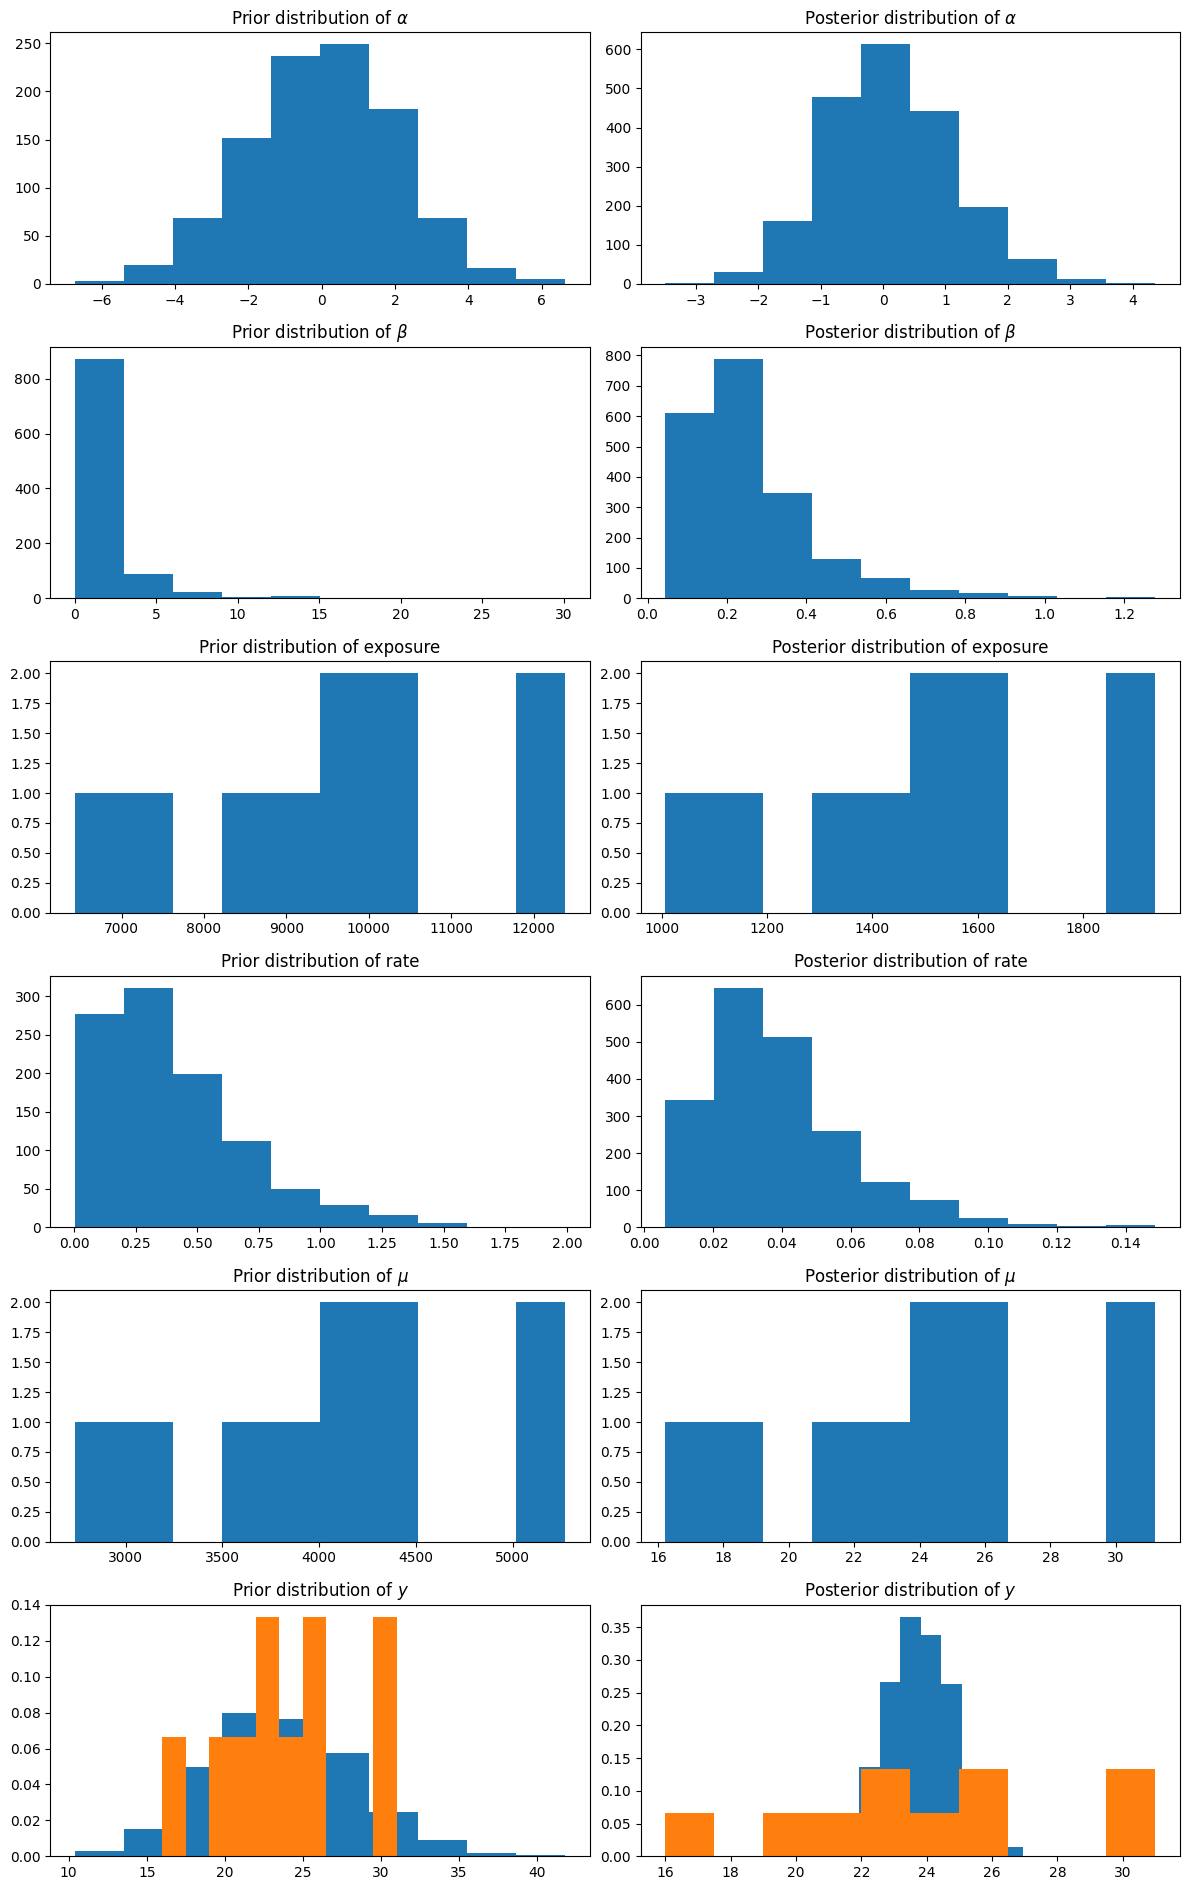

In [61]:
_, axes = plt.subplots(6, 2, figsize=(12, 19))

axes[0][0].hist(prior_b.prior["alpha"].mean("chain"))
axes[0][1].hist(trace_b.posterior["alpha"].mean("chain"))

axes[0][0].set_title(r"Prior distribution of $\alpha$")
axes[0][1].set_title(r"Posterior distribution of $\alpha$")

axes[1][0].hist(prior_b.prior["beta"].mean("chain"))
axes[1][1].hist(trace_b.posterior["beta"].mean("chain"))

axes[1][0].set_title(r"Prior distribution of $\beta$")
axes[1][1].set_title(r"Posterior distribution of $\beta$")

axes[2][0].hist(prior_b.prior["exposure"].mean(("chain", "draw")))
axes[2][1].hist(trace_b.posterior["exposure"].mean(("chain", "draw")))

axes[2][0].set_title(r"Prior distribution of exposure")
axes[2][1].set_title(r"Posterior distribution of exposure")

axes[3][0].hist(prior_b.prior["rate"].mean("chain"))
axes[3][1].hist(trace_b.posterior["rate"].mean("chain"))

axes[3][0].set_title(r"Prior distribution of rate")
axes[3][1].set_title(r"Posterior distribution of rate")

axes[4][0].hist(prior_b.prior["mu"].mean(("chain", "draw")))
axes[4][1].hist(trace_b.posterior["mu"].mean(("chain", "draw")))

axes[4][0].set_title(r"Prior distribution of $\mu$")
axes[4][1].set_title(r"Posterior distribution of $\mu$")

axes[5][0].hist(
    prior_a.prior_predictive["accidents"].mean(("chain", "accidents_dim_0")),
    density=True,
)
axes[5][0].hist(data["accidents"].to_list(), density=True)
axes[5][1].hist(
    posterior_a.posterior_predictive["accidents"].mean(("chain", "accidents_dim_0")),
    density=True,
)
axes[5][1].hist(data["accidents"].to_list(), density=True)

axes[5][0].set_title("Prior distribution of $y$")
axes[5][1].set_title("Posterior distribution of $y$")

plt.tight_layout()
plt.show()

In [75]:
with model_b:
    pm.set_data({"miles": [8e11 / 100_000_000]})

    predictions = pm.sample_posterior_predictive(
        trace=trace_b,
        predictions=True,
        var_names=["accidents"],
    )

Sampling: [accidents]


Output()

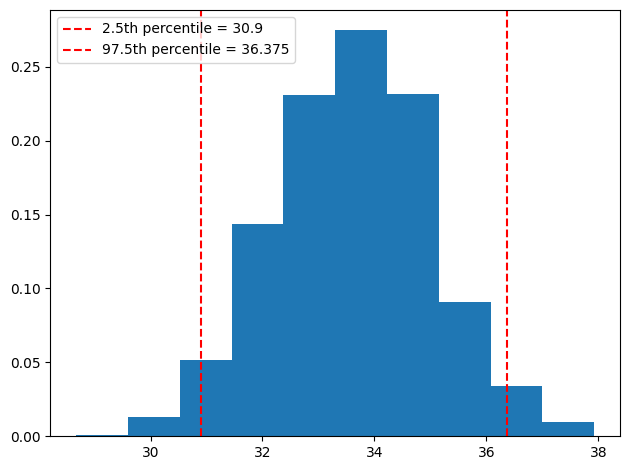

In [76]:
predictions = predictions.predictions["accidents"].mean(("chain", "accidents_dim_0"))

plt.hist(predictions, density=True)

plt.axvline(
    np.percentile(predictions, 2.5),
    linestyle="--",
    color="red",
    label=f"2.5th percentile = {np.percentile(predictions, 2.5)}",
)

plt.axvline(
    np.percentile(predictions, 97.5),
    linestyle="--",
    color="red",
    label=f"97.5th percentile = {np.percentile(predictions, 97.5)}",
)

plt.legend()
plt.tight_layout()
plt.show()